## Simulation of level density analysis

Simulate a spectrum (with parameters to mimic $^{154}$Sm).

Taken from uct2018b/notebooks

1. Level spacing according to Wigner distribution.
2. Level intensity from Porter-Thomas distribution.
3. Experimental resolution of 40 keV FWHM.
4. Simulation constructed on expanded grid and then compressed into bins of 5 keV width.
5. Noise is added after the spectrum is constructed, to simulate the effect of counting statistics.
6. Only a constant spectrum.
7. Level spacing parameter is energy dependent.

8. Two methods of simulating spectrum (brute force and quick).

### Results.

1. Noise correction is applied.
2. Provided $\sigma$ is kept constant, good results are obtained for both narrow smoothing and with no narrow smoothing.
3. Even with $\sigma$ a fit parameter, results are good.
4. With $\sigma$ a fit parameter and no noise correction, results are worse.

### Conclusions.

Noise corrections are important.

***
### Index
1. [Imports](#Imports)
2. [Setup](#Setup)
3. [Smoothing](#Smoothing)
4. [Simulation](#Simulation)

***
### Imports

In [1]:
import sys
sys.path.append('../../uct2018b/notebooks')
import numpy as np
import numpy.random as rnd
import spectrumtools as spt
import matplotlib.pyplot as plt
import leveldensities as ldn
import lmfit
import simlibx as sim
import spectrumtools as spt

plt.rc('font',size=16)

***
### Setup

In [18]:
Noisy=True
#Noisy=False
# do we use narrow smoothing as well as wide?
NarrowSmooth=True
NarrowSmooth=False

ZapCorrection=False

# use quick simulation method
UseQuickSim = True

D0=0.0001054
def De(E):
    return D0
    return D0*np.exp(-(E-10.0)/2.0)

Eres=20.0
Gamma=6.0

def E1res(e,gamma,eres):
    return e*gamma/((e**2-eres**2)**2+e**2*gamma**2)

def simulate_spectrum(Elo,Ehi,binwidth,lineshape, sigma, factor=10.0, noisy=False):
    """
    from simlib; modified
    generate a simulted spectrum in Nspect channels
    with a mean of Npk peaks.
    Each line has a shape and width determined by linehape and sigma (in channels)
    """
    Nspect=int((Ehi-Elo)/binwidth+0.5)
    w0=binwidth/10.0
    sig=sigma/w0
    g=np.zeros(Nspect*10)
    nDg=np.zeros(Nspect*10)
    D0=0.0001054  # mean level spacing
    #print('** D=',D, '    rho=',1.0/D)
    e = Elo            # peak energy
    spectrum=[]
    N=0
    while e < Ehi:
        N+=1
        x=De(e)*sim.randomWigner()          # random level space
        y=sim.randomPT()                     # random strength
        e+=x                             # energy of level
        spectrum.append((e,y))
        ne=int((e-Elo)/w0+0.5)                    # force energy to nearest channel
        if ne<Nspect*10.0: 
            g[ne]+=y                # into spectrum
            nDg[ne]+=1.0
    # convolute with line shape
    G=sim.convolute(g, lineshape, sig)#*1000.0
    #G=sim.convolute(G,lineshape,sig*0.8)
    G=G.reshape((Nspect,10))
    G=np.sum(G,axis=1)
    nDG=nDg.reshape((Nspect,10))
    nDG=np.sum(nDG,axis=1)
    g=g.reshape((Nspect,10))
    g=np.sum(g,axis=1)
    #factor=10.0
    #factor=1.0
    #Gshape=np.linspace(1.0,10.0,len(G))
    elor=np.linspace(Elo,Ehi,len(g))
    Llo=E1res(Elo,Gamma,Eres)
    meang=np.mean(G)
    #G=G*E1res(elor,Gamma,Eres)/Llo
    if noisy:
        #meang=np.mean(G)
        #G=G*Gshape
        sigG=np.sqrt(meang)#*E1res(elor,Gamma,Eres)/Llo)
        noiseG=rnd.randn(len(G))*sigG
        #print("noisy")
        #G=G+noiseG/factor
    #print(N,sig,w0,binwidth)
    return G, g, spectrum, noiseG, nDG  # improve this ?

def simulate_spectrum_quick(Elo,Ehi,binwidth,lineshape, sigma, factor=10.0, noisy=False):
    """
    from simlib; modified
    generate a simulted spectrum in Nspect channels
    with a mean of Npk peaks.
    Each line has a shape and width determined by linehape and sigma (in channels)
    """
    from scipy.stats import chi2
    Nspect=int((Ehi-Elo)/binwidth+0.5)
    w0=binwidth/10.0
    sig=sigma/w0
    g=np.zeros(Nspect*10)
    D0=0.0001054  # mean level spacing
    #print('** D=',D, '    rho=',1.0/D)
    ND=int(w0/D0+0.5)
    ND=float(ND)
    varND=ND*0.273
    sigND=np.sqrt(varND)
    print("ND",ND)
    e = Elo            # peak energy
    # convolute with line shape
    for i in range(Nspect*10):
        Dbin=ND+rnd.randn()*sigND
        while Dbin <0.0:
            print('Dbin',i,Dbin)
            Dbin=ND+rnd.randn()*sigND
        sigg=np.sqrt(2.0*Dbin)
        #g[i]=(binwidth/D0)+rnd.randn()*sigg
        #g[i]=Dbin+rnd.randn()*sigg
        g[i]=chi2.rvs(df=ND)
        if g[i] <=0.0 or g[i]>=100.0:
            print("**",i,g[i])
    G=sim.convolute(g, lineshape, sig)#*1000.0
    G=G.reshape((Nspect,10))
    G=np.sum(G,axis=1)
    g=g.reshape((Nspect,10))
    g=np.sum(g,axis=1)
    #G=sim.convolute(G,lineshape,sig*0.8)
    elor=np.linspace(Elo,Ehi,len(g))
    Llo=E1res(Elo,Gamma,Eres)
    meang=np.mean(G)
    #G=G*E1res(elor,Gamma,Eres)/Llo
    if noisy:
        #meang=np.mean(G)
        #G=G*Gshape
        sigG=np.sqrt(meang)#*E1res(elor,Gamma,Eres)/Llo)
        noiseG=rnd.randn(len(G))*sigG
        #print("noisy")
        #G=G+noiseG/factor
    #print(N,sig,w0,binwidth)
    return G, g, None, noiseG  # improve this ?


In [19]:
#e=np.linspace(10.0,30.0,200)
#plt.plot(e,E1res(e,Gamma,Eres))

***
### Smoothing

In [20]:
# The following parameters should probably remain fixed

# lineshape for convolutions
lineshape=sim.gauss

# set smoothing parameters in channels
smoothwide=3.5 # from 3.5
smoothnarrow=0.39*2.35

alpha=2.0+0.273            # default for N=1

esig,sig=0.0,33.0 # fwhm of experimental resolution in keV  <<<<<<<<<<<<<<<<<<<<<<<<<
print("Assumed fwhm of resolution fn is %5.1f keV"%(sig))
print(":Smooth factors: wide %5.1f; narrow %5.2f"%(smoothwide,smoothnarrow))
# convert to sdev of gaussian in MeV
sig/=1000.0   # sig in MeV
sig/=2.35      # FWHM to stdev
#print("sig",sig, sig*2.3)
# calculate smoothing widths
sigsmn=smoothnarrow*sig       # < sig   . should be 0.5*FWHM ?
sigsm=smoothwide*sig       # in MeV
sigexpt=sig
sigsm0=sigsm
sigx=sigsm*2


Assumed fwhm of resolution fn is  33.0 keV
:Smooth factors: wide   3.5; narrow  0.92


***
### Simulation

In [21]:
D=0.0001054
Dinit=D
de=0.005
# at 5 keV / channel
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800

ROIlo=ROIlo+50
ROIhi=ROIhi+50

rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV

#rnd.seed( 75096521 )

#rnd.seed( 31415 )

de=0.005
rawG,hraw,rawspectrum,rawnoiseG,nDG=simulate_spectrum(10.0,20.0,de,sim.gauss,
                                         sig,
                                         factor=10.0,noisy=Noisy)
rawG0,hraw0,rawspectrum0,rawnoiseG0=simulate_spectrum_quick(10.0,20.0,de,sim.gauss,
                                         sig,
                                         factor=10.0,noisy=Noisy)
X=np.arange(0.0,2000.0,1.0)*0.005+10.0
e=X
Nspect=len(rawG)
Nlo=ROIlo
Nhi=ROIhi
Exlo,Exhi=(e[ROIlo],e[ROIhi])
print(Exlo,Exhi)

print("ROI for analysis",Nlo, Nhi, ROIlo, ROIhi)


ND 5.0
Dbin 9028 -0.2530667389859005
11.25 19.25
ROI for analysis 250 1850 250 1850


Variances 111.14470723026287 102.07492121192563


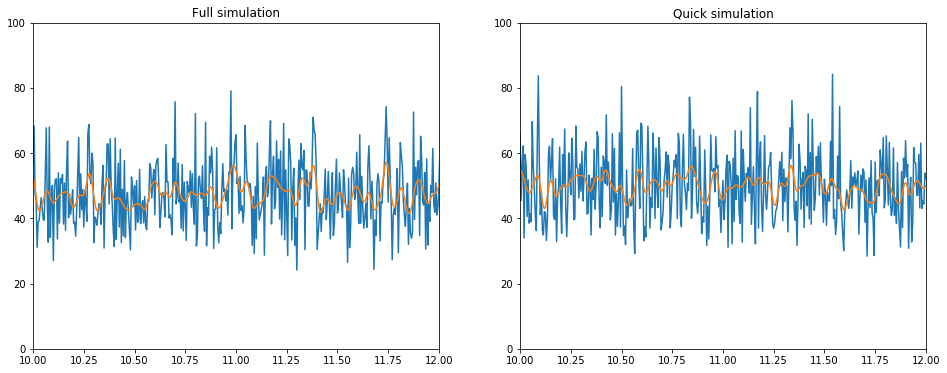

In [22]:
plt.figure(figsize=(16,6))
plt.subplot(121)
plt.title('Full simulation')
plt.plot(e,hraw)
plt.plot(e,rawG)
plt.ylim(0.0,100.0)
plt.xlim(10.0,12.0)
plt.subplot(122)
plt.title('Quick simulation')
plt.plot(e,hraw0)
plt.plot(e,rawG0)
plt.ylim(0.0,100.0)
plt.xlim(10.0,12.0)
xlo=0
xhi=int((12.0-10.0)/de+0.1)
print('Variances',np.var(hraw0[xlo:xhi]),np.var(hraw[xlo:xhi]))

47.36 94720.0 44.721359549995796
0.999999999999999 0.9995510954965104


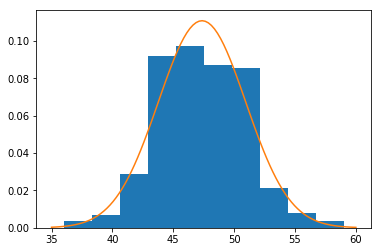

In [23]:
meanDG=np.mean(nDG)
totDG1=np.sum(nDG)
xDG=np.linspace(35.0,60.0,100)
dxDG=xDG[1]-xDG[0]
h,tmp,tmp2=plt.hist(nDG,density=True)
totDG=np.sqrt(len(nDG))
thDG=np.exp(-(xDG-meanDG)**2/(2.0*meanDG*0.273))/(np.sqrt(2.0*np.pi*meanDG*0.273))
plt.plot(xDG,thDG)
#plt.ylim(0.0,100.0)
#plt.xlim(10.0,12.0)
print(meanDG,totDG1,totDG)
print(np.sum(h)*(tmp[1]-tmp[0]),np.sum(thDG)*dxDG)

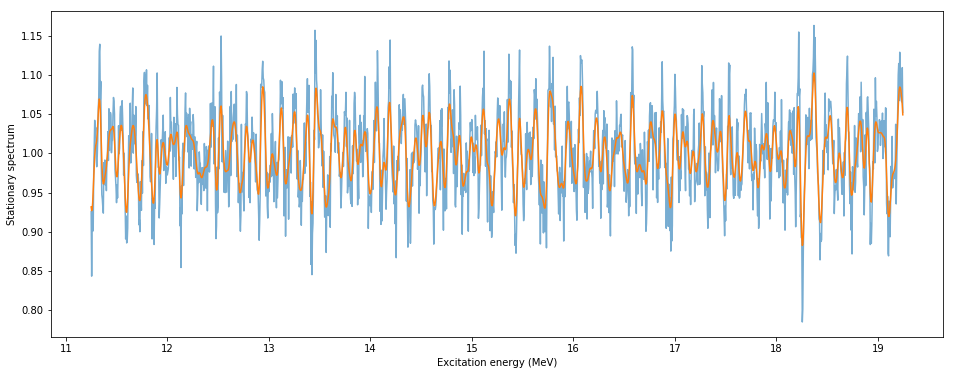

In [24]:
noisefactor=5.0
if UseQuickSim:
    G=rawG0+rawnoiseG0/noisefactor
else:
    G=rawG+rawnoiseG0/noisefactor
    
S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
globalenergy = S.energy

if NarrowSmooth:
    iAC=0             # first point in autocorrelation fit
    firstoffset=0.0       # energy offset of first point
else:                 # if no narrow smooth, ignore noise in first channel
    iAC=1
    firstoffset=de

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

Eratio=S.Eratio
ratioraw=S.ratioraw
rationar=S.rationar

plt.figure(figsize=(16,6))
plt.plot(Eratio, ratioraw, alpha=0.6)
plt.plot(Eratio, rationar)
#plt.plot(Eratio,S.data[ROIlo:ROIhi])
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Stationary spectrum")
plt.show()

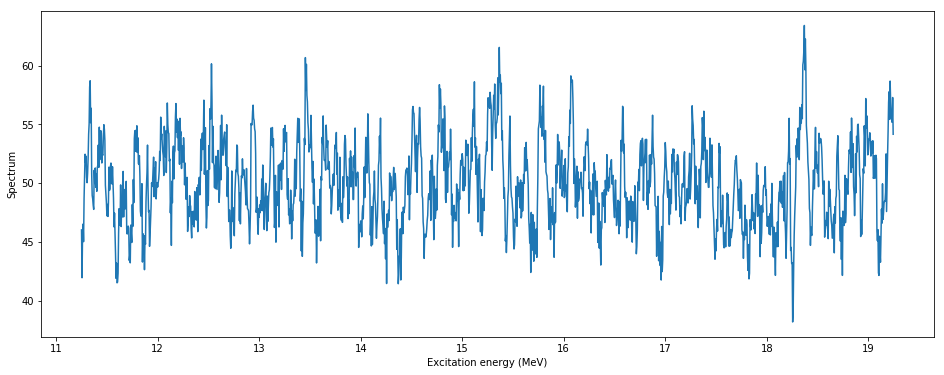

In [25]:
plt.figure(figsize=(16,6))
plt.plot(Eratio,G[ROIlo:ROIhi])
#plt.plot(Eratio,S.data[ROIlo:ROIhi])
plt.xlabel("Excitation energy (MeV)")
plt.ylabel("Spectrum")
plt.show()

In [26]:
def fitforlm( params, e, data, unc=None ):
    """
    fit function for least sq fit using lmfit
    """
    global alpha
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    #sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    model*=np.exp(-e*e/(2.0*sigx**2))
    if unc is None:
        unc=np.ones(len(data))*p['initD']*0.2
    return (model-data)/unc

def model(params, e):
    p=params.valuesdict()
    D=p['D']
    sign=p['sign']
    sigw=p['sigw']
    sigx=p['sigx']
    ys=sigw/sign
    ysp=1.+ys*ys
    sig=sign
    model=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.exp(-e*e/(4.*sig*sig))
    model+=(1.0/(2.0*np.sqrt(np.pi)*sig*ys))*(alpha*D)*np.exp(-e*e/(4.*sig*sig*ys*ys))
    model-=(1.0/(2.0*np.sqrt(np.pi)*sig))*(alpha*D)*np.sqrt(8./ysp)*np.exp(-e*e/(2.*sig*sig*ysp))
    #model*=np.exp(-e*e/(2.0*sigx**2))
    return model

In [27]:
ifig=1
Varysign=True
#UseQuickSim=True
print("NarrowSmooth ",NarrowSmooth)
print("ZapCorrection", ZapCorrection)
print("Varysig_n    ", Varysign)
print("UseQuickSim  ",UseQuickSim)
noisefactors=[10.0,5.0,3.0,2.0,1.5,1.2,1.0]
computedrho=[] # computed from AC[0]-noise, expt sign
#NarrowSmooth=True

NarrowSmooth  False
ZapCorrection False
Varysig_n     True
UseQuickSim   True


800 1200
initialD 0.000050 estimated from AC 0.002277
noisecorrection 0.00029225784757775324
[[Variables]]
    D:      8.6033e-05 +/- 4.2929e-07 (0.50%) (init = 4.985818e-05)
    sign:   0.01404255 (fixed)
    sigw:   0.05111567 (fixed)
    sigx:   0.09829787 (fixed)
    initD:  0.0001994327 (fixed)
11450.095272662527 8.733551784390234e-05 0.0019816606228428603
0.005 0.014042553191489362 0.051115665180054705 2.273 1
At 0 0.0019816606228428603 0.002064174578425189 22.690202929634516
Computed rho 11450.095272662527
800 1200
initialD 0.000060 estimated from AC 0.002761
noisecorrection 0.0008492526788158381
[[Variables]]
    D:      8.3214e-05 +/- 5.4946e-07 (0.66%) (init = 6.046891e-05)
    sign:   0.01404255 (fixed)
    sigw:   0.05111567 (fixed)
    sigx:   0.09829787 (fixed)
    initD:  0.0002418756 (fixed)
11885.554613301321 8.413574566229189e-05 0.0019090571427135198
0.005 0.014042553191489362 0.051115665180054705 2.273 1
At 0 0.0019090571427135198 0.0019965527273310335 22.6902029296

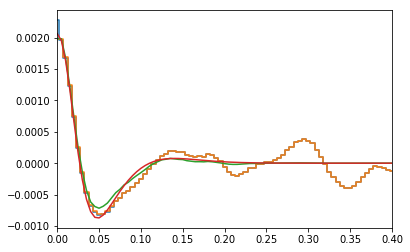

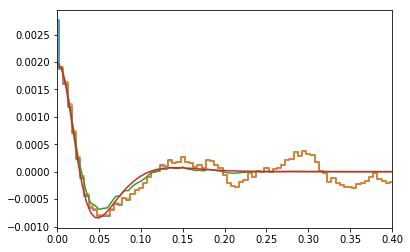

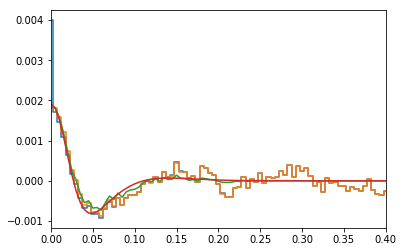

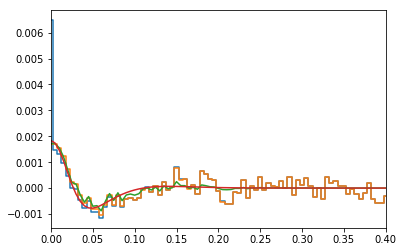

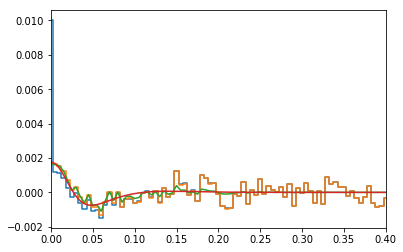

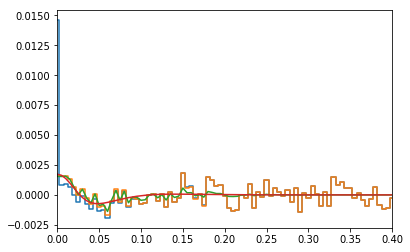

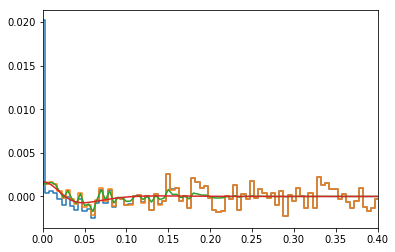

In [28]:
rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV
ROIlo,ROIhi=(40*5,360*5)  # 1600 chans: 200 - 1800

ROIlo=ROIlo+50
ROIhi=ROIhi+50

#rnd.seed( 75096521 )

#rawG,hraw,rawspectrum,rawnoiseG=simulate_spectrum(10.0,20.0,0.005,sim.gauss,
#                                         sig,
#                                         factor=10.0,noisy=Noisy)
computedrho=[] # computed from AC[0]-noise, expt sign
evals=[]
rhovals=[]
for noisefactor in [10.0,5.0,3.0,2.0,1.5,1.2,1.0]:
#for noisefactor in [1.0]:
    if UseQuickSim:
        G=rawG0+rawnoiseG0/noisefactor                     #                        Note:  quick sim !
    else:
        G=rawG+rawnoiseG/noisefactor                     # 
        
    S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
    globalenergy = S.energy

    S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

    Eratio=S.Eratio
    ratioraw=S.ratioraw
    rationar=S.rationar
    """
    plt.figure(figsize=(16,6))
    plt.plot(Eratio, ratioraw, alpha=0.6)
    plt.plot(Eratio, rationar)
    #plt.plot(Eratio,S.data[ROIlo:ROIhi])
    plt.xlabel("Excitation energy (MeV)")
    plt.ylabel("Stationary spectrum")
    plt.show()
    """
    bins=spt.ACBinner(S,NAC=4,Nslides=2)
    #print("Computed bin limits:\n",bins.get_bins())
    binlist=bins.get_bins()
    index=4
    l,h=binlist[index]
    print(l,h)
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    if NarrowSmooth:
        data=bin.acnar
    else:
        data=bin.acraw
    # calculate alpha from M1 fraction assuming N1=N2
    # first get mean m1 fraction

    # increase sig to account for convolution of g
    sigw=np.sqrt(sig**2+sigsm**2)#sqrt(1.25)*sig
    sign=sig
    if NarrowSmooth:
        sign=np.sqrt(sig**2+sigsmn**2)#sqrt(1.25)*sig
        sigaim=sig
    ys=sigw/sign
    ys=sigw/sign
    alpha=2.273
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    print("initialD %8.6f estimated from AC %8.6f"%(initialD,data[0]))
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sign,min=0.0, vary=False)
    params.add('sigw',value=sigw,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    params.add('initD',value=initialD*4,vary=False)
    noise=bin.get_noise_correction2(sigsmn, sigsm, NarrowSmooth)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
    print("noisecorrection",noise[0])
    #ACfx=data*np.exp(-energy**2/(2.0*sigx**2))
    #initial=1.0
    #popt,pcov=curve_fit(fitf2, Xac, ACf, p0=[initial,sig])
    #sig=popt[1]
    #popt[0]*=initialD
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx))
                           #fcn_kws={'unc'=uncert})
    result=minner.minimize()
    m=model(result.params, energy)
    lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    Ntypes = 1 
    signf=p['sign']
    sigwf=p['sigw']
    D=ACfx[0]/spt.ACtheory(de,signf,sigwf,alpha,1.0)*Ntypes
    D=ACfx[1]/spt.ACtheory(de,sign,sigw,alpha,1.0)*Ntypes
    #D=p["D"]*Ntypes
    rho=1.0/D
    print(rho, D, ACfx[iAC])
    
    plt.figure()
    plt.plot(energy, data, drawstyle='steps-mid')
    plt.plot(energy, data-noise, drawstyle='steps-mid')
    plt.plot(energy,ACfx)
    plt.plot(energy, m)
    plt.xlim(0.0,energy[-1]/4)
    plt.xlim(0.0,0.4)
    """ 
    plt.plot(bin.spectrumraw)
    """
    print(de,p['sign'],sigw,alpha,iAC )
    print("At 0", ACfx[iAC], m[0], spt.ACtheory(de,p['sign'],sigw,alpha,1.0))
    print("Computed rho",1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))
    computedrho.append(1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))

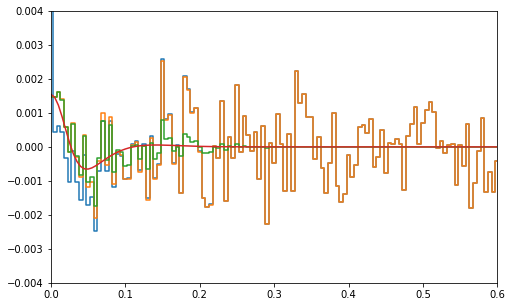

In [29]:
# replot of last
plt.figure(figsize=(8,5))
plt.plot(energy, data, drawstyle='steps-mid')
plt.plot(energy, data-noise, drawstyle='steps-mid')
plt.plot(energy,ACfx, drawstyle='steps-mid')
m=spt.ACtheory(energy, sign, sigw, alpha, D)
plt.plot(energy, m)
plt.xlim(0.0,energy[-1]/4)
plt.xlim(0.0,0.6)
plt.ylim(-0.004,0.004)
plt.show()

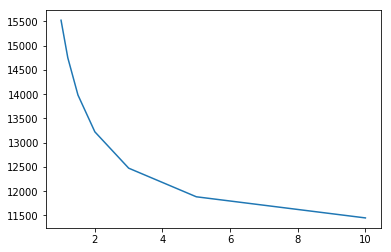

In [30]:
plt.plot(noisefactors,computedrho)

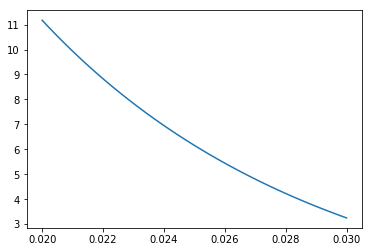

In [15]:
sn=np.linspace(0.020,0.030,50)
hf=spt.ACtheory(de,sn,sigw,alpha,1.0)
plt.plot(sn,hf)

0 400 11.25 13.245000000000001
initialD 0.000028 estimated from AC 0.001258
noisecorrection 9.210613910382267e-06
[[Variables]]
    D:      9.8733e-05 +/- 6.2013e-06 (6.28%) (init = 2.754742e-05)
    sign:   0.0190481 (fixed)
    sigw:   0.05111567 (fixed)
    sigx:   0.09829787 (fixed)
    initD:  0.0001101897 (fixed)
10237.240668874663
0.005 0.01904810227124498 0.051115665180054705 2.273 1
At 0 0.0012486408825094994 0.0012795340416064645 12.49411036859257
Computed rho 10479.238017640926
200 600 12.25 14.245000000000001
initialD 0.000025 estimated from AC 0.001155
noisecorrection 6.839867200647145e-06
[[Variables]]
    D:      9.1044e-05 +/- 6.5652e-06 (7.21%) (init = 2.529953e-05)
    sign:   0.0190481 (fixed)
    sigw:   0.05111567 (fixed)
    sigx:   0.09829787 (fixed)
    initD:  0.0001011981 (fixed)
11074.160414386735
0.005 0.01904810227124498 0.051115665180054705 2.273 1
At 0 0.001148370108856134 0.0011799003775372816 12.49411036859257
Computed rho 11275.522861115376
400 800 13.

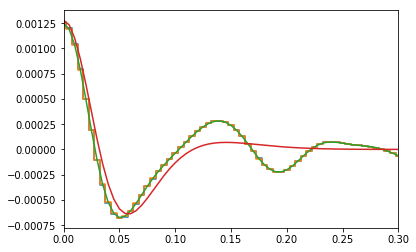

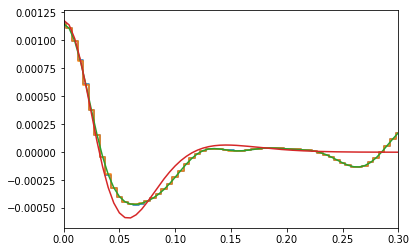

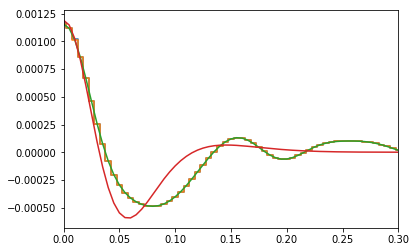

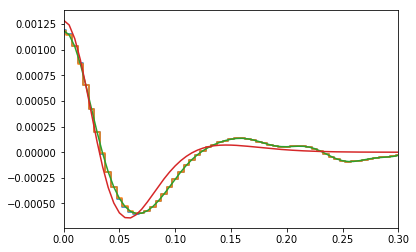

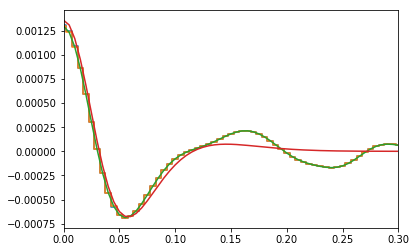

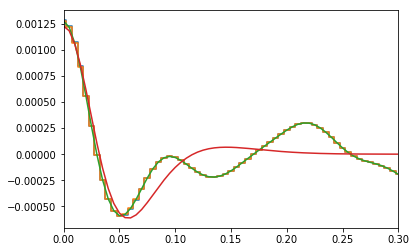

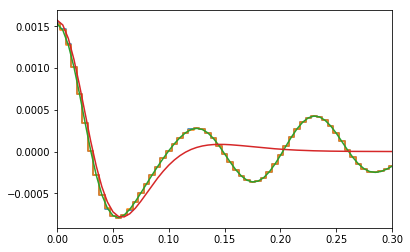

In [16]:
NarrowSmooth=True
computedrho=[] # computed from AC[0]-noise, expt sign

noisefactor=3.0
if UseQuickSim:
    G=rawG0+rawnoiseG0/noisefactor
else:
    G=rawG#+rawnoiseG/noisefactor

S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
globalenergy = S.energy

S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )

Eratio=S.Eratio
ratioraw=S.ratioraw
rationar=S.rationar

bins=spt.ACBinner(S,NAC=4,Nslides=2)
#print("Computed bin limits:\n",bins.get_bins())
binlist=bins.get_bins()

evals=[]
rhovals=[]
for b in bins.get_bins():
    l,h=b
    print(l,h,Eratio[l],Eratio[h-1])
    bin=spt.Bin(bins.data,l,h)
    energy=bin.Eoffset
    data=bin.acnar
    # calculate alpha from M1 fraction assuming N1=N2
    # first get mean m1 fraction

    # increase sig to account for convolution of g
    sigw=np.sqrt(sig**2+sigsm**2)#sqrt(1.25)*sig
    sign=sig
    if NarrowSmooth:
        sign=np.sqrt(sig**2+sigsmn**2)#sqrt(1.25)*sig
        sigaim=sig
    ys=sigw/sign
    alpha=2.273
    initialD=data[0]*(2.0*np.sqrt(np.pi)*sig)/alpha
    print("initialD %8.6f estimated from AC %8.6f"%(initialD,data[0]))
    ndata=len(data)
    params=lmfit.Parameters()
    params.add('D',value=initialD, min=0.0)
    params.add('sign',value=sign,min=0.0, vary=False)
    params.add('sigw',value=sigw,min=0.0,vary=False)
    params.add('sigx',value=sigx,vary=False)
    params.add('initD',value=initialD*4,vary=False)
    noise=bin.get_noise_correction2(sigsmn, sigsm, NarrowSmooth)
    uncert=np.linspace(data[0]/10,data[0]/5,ndata)
    ACfx=(data-noise)######*np.exp(-energy**2/(2.0*sigx**2))
    print("noisecorrection",noise[0])
    minner=lmfit.Minimizer(fitforlm, params, fcn_args=(energy,ACfx))
                           #fcn_kws={'unc'=uncert})
    result=minner.minimize()
    m=model(result.params, energy)
    lmfit.printfuncs.report_fit(result.params)
    p=result.params.valuesdict()
    Ntypes = 1 
    signf=p['sign']
    sigwf=p['sigw']
    D=(ACfx[0]+ACfx[1])/2/spt.ACtheory(de,signf,sigwf,alpha,1.0)*Ntypes
    #m=spt.ACtheory(energy,signf,sigwf,alpha,D)*Ntypes
    #D=p["D"]*Ntypes
    rho=1.0/D
    print(rho)
    rhovals.append(rho)
    evals.append((Eratio[h-1]+Eratio[l])/2)
    
    plt.figure()
    plt.plot(energy, data, drawstyle='steps-mid')
    plt.plot(energy, data-noise, drawstyle='steps-mid')
    plt.plot(energy,ACfx)
    plt.plot(energy, m)
    plt.xlim(0.0,energy[-1]/4)
    plt.xlim(0.0,0.3)
    """ 
    plt.plot(bin.spectrumraw)
    """
    print(de,p['sign'],sigw,alpha,iAC )
    print("At 0", ACfx[0], m[0], spt.ACtheory(de,p['sign'],sigw,alpha,1.0))
    print("Computed rho",1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))
    computedrho.append(1.0/(ACfx[iAC]/spt.ACtheory(de,sign,sigw,alpha,1.0)))

9487.666034155598 9487.666034155598 9487.666034155598


(5000, 2000000)

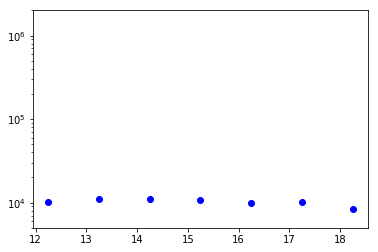

In [17]:
print(1.0/D0,1.0/De(10.0),1.0/De(12.0))
plt.figure()
erho=np.linspace(12.0,18.0,100)
rho=1.0/De(erho)
plt.semilogy(evals,rhovals,'bo')
#plt.semilogy(erho,rho,'r-')
plt.ylim(5000,2000000)

In [32]:
computedrho=[] # computed from AC[0]-noise, expt sign
noisefactor=3.0
sigw=np.sqrt(sig**2+sigsm**2)#sqrt(1.25)*sig
sign=sig
if NarrowSmooth:
    sign=np.sqrt(sig**2+sigsmn**2)#sqrt(1.25)*sig
    sigaim=sig
ys=sigw/sign
alpha=2.273

rnd.seed( 271 )  # fix state of RNG -> rho=6687/MeV

for i in range(200):
    rawG,hraw,rawspectrum,rawnoiseG=simulate_spectrum(10.0,20.0,0.005,sim.gauss,
                                         sig,
                                         factor=10.0,noisy=Noisy)
    G=rawG+rawnoiseG/noisefactor
    S=spt.RatioSpectrum( X, G, None, ROIlo, ROIhi )
    globalenergy = S.energy

    S.makeRatioSpectra( sigsmn*1000, sigsm*1000 )


    bins=spt.ACBinner(S,NAC=4,Nslides=2)
    #print("Computed bin limits:\n",bins.get_bins())
    binlist=bins.get_bins()

    for b in bins.get_bins():
        l,h=b
        #print(l,h)
        bin=spt.Bin(bins.data,l,h)
        energy=bin.Eoffset
        data=bin.acnar
        noise=bin.get_noise_correction(sigsmn, sigsm)
        uncert=np.linspace(data[0]/10,data[0]/5,ndata)
        ACfx=(data-noise)*np.exp(-energy**2/(2.0*sigx**2))
        D=ACfx[0]/spt.ACtheory(de,sign,sigw,alpha,1.0)#*Ntypes
        rho=1.0/D
        computedrho.append(rho)
print("DONE")

DONE


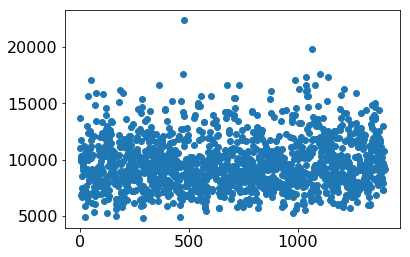

In [52]:
plt.plot(computedrho,'o')

Text(0,0.5,'Probability density')

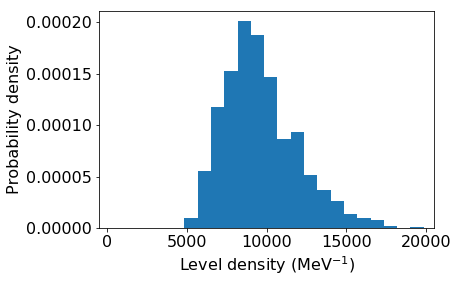

In [61]:
crho=np.array(computedrho)
plt.hist(crho,bins=21,density=True)
plt.xlim(-500,20500)
plt.xlabel(r"Level density (MeV$^{-1}$)")
plt.ylabel(r"Probability density")

In [62]:
print(np.mean(crho), np.sqrt(np.var(crho/np.mean(crho))))

9641.412281977095 0.24039490667941615


In [63]:
print(np.mean(crho)/np.sqrt(np.var(crho)), 0.81/2.37)

4.159821910593021 0.34177215189873417
